<a href="https://colab.research.google.com/github/LucasSSales/Lista01-Visao-Computacional/blob/main/Lista01_VC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [128]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
#imagens para questao 01
img01 = cv.imread(cv.samples.findFile("first_frame.jpg"))
img02 = cv.imread(cv.samples.findFile("second_frame.jpg"))
img02_rszd = cv.resize(img02, (img01.shape[1], img01.shape[0]))

#imagens com ruidos
sp_noise = cv.imread(cv.samples.findFile("sp_noise.jpg"), flags = cv.IMREAD_GRAYSCALE)
gaussian_noise = cv.imread(cv.samples.findFile("gaussian_noise.jpg"), flags = cv.IMREAD_GRAYSCALE)
maki_gray = cv.imread(cv.samples.findFile("sp_noise.jpg"), flags = cv.IMREAD_GRAYSCALE )

#imagens rgb
maki = cv.imread(cv.samples.findFile("maki.jpg"))
eu = cv.imread(cv.samples.findFile("eu.jpg") )
otoya = cv.imread(cv.samples.findFile("otoya.jpg") )
maki1024 = cv.imread(cv.samples.findFile("Maki1024.jpg"))

#imagens grayscale
maki_gs = cv.imread(cv.samples.findFile("maki.jpg"), flags = cv.IMREAD_GRAYSCALE )
eu_gs = cv.imread(cv.samples.findFile("eu.jpg"), flags = cv.IMREAD_GRAYSCALE )
otoya_gs = cv.imread(cv.samples.findFile("otoya.jpg"), flags = cv.IMREAD_GRAYSCALE )
maki1024_gs = cv.imread(cv.samples.findFile("Maki1024.jpg"), flags = cv.IMREAD_GRAYSCALE )
maki256_gs = cv.imread(cv.samples.findFile("maki256.jpg"), flags = cv.IMREAD_GRAYSCALE )
img01_gs = cv.imread(cv.samples.findFile("first_frame.jpg"), flags = cv.IMREAD_GRAYSCALE )
img02_gs = cv.imread(cv.samples.findFile("second_frame.jpg"), flags = cv.IMREAD_GRAYSCALE )
img02_gs_rszd = cv.resize(img02_gs, (img01_gs.shape[1], img01_gs.shape[0]))

In [6]:
#FUNÇÕES AUXILIARES

# Pega uma submatriz de uma matriz especificada
# parametros: 
# m: matriz, l0
# indice da linha inicial
# l1: indice da linha final
# c0: indice da coluna inicial
# c1: indice da coluna final
# retorno: submatriz com dimensões (l1-l0, c1-c0)
def submatrix(m, l0, l1, c0, c1):
  if (l0 < 0): l0 = 0
  if (c0 < 0): c0 = 0
  if (l1 >= len(m)): l1 = len(m)-1
  if (c1 >= len(m[0])): c1 = len(m[0])-1
  sub = []
  for i in range(len(m)):
    if (l0 <= i and l1 >= i):
      sub.append(m[i][c0:c1+1])
  return np.array(sub)

def evaluated_s(s):
  for i in range(len(s)):
    if (s[i] > 255): s[i] = 255
    if (s[i] < 0): s[i] = 0
  if (len(s)==1):
    return s[0]
  return s

#calcula o valor para o pixel do meio
def calc_mid_pxl(subm, kernel, convolution = False, isRGB = False):
  if (convolution): np.flip(kernel)
  s = 0
  for i in range(len(kernel)):
    s += np.dot(kernel[i], subm[i].T)

  if (np.isscalar(s)):
    s = [s]
  s = evaluated_s(np.array(s))
  return s

def zeros_in_gap(subm, l0, c0, k_dim):
  zeros = np.zeros((k_dim, k_dim), np.uint8)
  start = {"l":0, "c":0}
  if (l0 < 0): start["l"] = abs(l0)
  if (c0 < 0): start["c"] = abs(c0)
  for u in range(len(subm)):
    for v in range(len(subm[u])):
      zeros[start["l"]+u][start["c"]+v] = subm[u][v]
  return zeros

# QUESTÃO 01

A ideia utilizada foi tentar percorrer a imagem com a pessoa e a cada pixel fazer uma analise dos canais rgb, de modo a tentar adivinhar se pela ordenação dos tons (por exemplo o canal [90 103 100] teria como tom mais forte o indice 1 e como mais fraco o indice 0, entao ele é classe "120", assim com as possiveis classes geradas (nos casos de repetirem os valores e não ser possivel dizer qual deles é o canal mais relevante), comparar pra ver se é possível que o pixel analisado na imagem 2 comparado ao equivalente na imagem 1 seja um pixel de background ou do foreground

No momento, o código não foi um sucesso e partes do foreground foram apagadas, assim como parte do background estão expostas

In [133]:
def get_combs(rgb):
  combs = []
  min = np.where(rgb == np.amin(rgb))
  max = np.where(rgb == np.amax(rgb))

  if (len(max[0]) == 1 and len(min[0]) == 1):
    middle = np.intersect1d(np.where(rgb != np.amax(rgb))[0], np.where(rgb != np.amin(rgb))[0])
    s = str(max[0][0]) + str(middle[0]) + str(min[0][0])
    combs.append(s)
  elif (len(max[0]) == 2):
    s = str(max[0][0]) + str(max[0][1]) + str(min[0][0])
    combs.append(s)
    s = str(max[0][1]) + str(max[0][0]) + str(min[0][0])
    combs.append(s)
  elif (len(min[0]) == 2):
    s = str(max[0][0]) + str(min[0][0]) + str(min[0][1])
    combs.append(s)
    s = str(max[0][0]) + str(min[0][1]) + str(min[0][0])
    combs.append(s)
  else:
    combs = ["all"]

    #tratando tons de cinza
  if ( (np.amin(rgb) > 200 and np.amax(rgb) > 200) or (subtract(np.amin(rgb), np.amax(rgb)) <= 10) ):
    combs.append("all")

  return combs

def can_be(comb1, comb2):
  for comb in comb1:
    if (comb in comb2):
      return True
  return False


def dist(rgb1, rgb2):
  x, y, z = rgb1[0]-rgb2[0], rgb1[1]-rgb2[1], rgb1[2]-rgb2[2]
  if (rgb1[0]<rgb2[0]):
    x = rgb2[0]-rgb1[0]

  if (rgb1[1]<rgb2[1]):
    y = rgb2[1]-rgb1[1]

  if (rgb1[2]<rgb2[2]):
    z = rgb2[2]-rgb1[2]

  return np.sqrt( np.power(x, 2) + np.power(y, 2) + np.power(z, 2) )


def subtract(x1, x2):
  if (x1 < x2):
    x1, x2 = x2, x1
  return x1 - x2

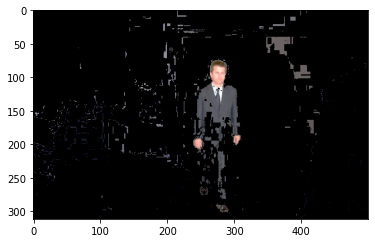

In [184]:
img03 = img02_rszd * 0
dists = img02_gs_rszd * 0
start = False
for i in range(len(img02_gs_rszd)):
  for j in range(len(img02_gs_rszd[i])):
    if (can_be(get_combs(img02_rszd[i][j]), get_combs(img01[i][j]))):
      img03[i][j] = 0
    else: img03[i][j] = img02_rszd[i][j]


#subd = submatrix(dists, 90, 110, 270, 290)
#print(subd[0])
plt.imshow(cv.cvtColor(img03, cv.COLOR_BGR2RGB))

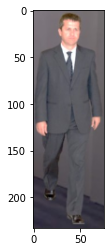

In [200]:
sub02 = submatrix(img02_rszd, 73, 305, 237, 312)
l0, l1, c0, c1 = 73, 305, 237, 312

plt.imshow(cv.cvtColor(sub02, cv.COLOR_BGR2RGB))

73 305 237 312


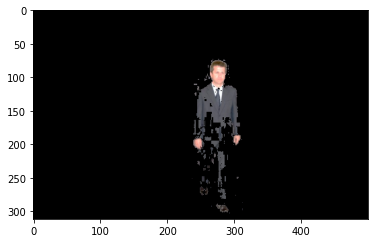

In [220]:
img03_02 = np.zeros( (img02_rszd.shape[0], img02_rszd.shape[1], img02_rszd.shape[2]), np.uint8 )

print(l0, l1, c0, c1)
for i in range(l0, l1+1):
  for j in range(c0, c1+1):
    if (can_be(get_combs(img02_rszd[i][j]), get_combs(img01[i][j]))):
      img03_02[i][j] = 0
    else: img03_02[i][j] = img02_rszd[i][j]

plt.imshow(cv.cvtColor(img03_02, cv.COLOR_BGR2RGB))



# QUESTÃO 02

PLOT DA IMAGEM 01


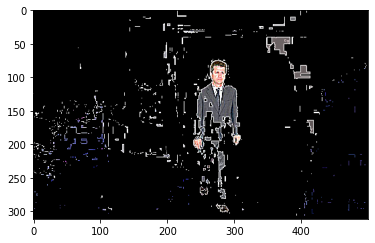

In [138]:
#O KERNEL UTILIZADO SERÁ:
#|-1 -1 -1|
#|-1  9 -1|
#|-1 -1 -1|

#definindo n
n = 3
#gerando o kernel
hpkernel = np.ones((n,n))*(-1)
mid = ((n*n))
hpkernel[n//2][n//2] = hpkernel[n//2][n//2]*(-mid)


#plotando a imagem 01
#dst = cv.filter2D(src = maki_gs, ddepth = -1, kernel = hpkernel, borderType=cv.BORDER_REPLICATE )
dst = cv.filter2D(img03, -1, hpkernel)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

# QUESTÃO 03

In [135]:
#função principal para aplicar o kernel
def applyFilter(img, kernel, isMedian = False, convolution = False, mode=False):
  new_img = img * 0
  k_dim = len(kernel)
  for i in range(len(img)):
    l0 = i - (k_dim//2)
    l1 = i + (k_dim//2)
    for j in range(len(img[i])):
      c0 = j - (k_dim//2)
      c1 = j + (k_dim//2)
      subm = submatrix(img, l0, l1, c0, c1)
      if (len(subm) < k_dim or len(subm[0]) < k_dim):
        subm = zeros_in_gap(subm, l0, c0, k_dim)
      if (isMedian):
        new_img[i][j] = np.median(subm)
      elif (mode):
        new_img[i][j] = stats.mode(subm)
      else:
        new_img[i][j] = calc_mid_pxl(subm, kernel, convolution)
        
  return new_img

True

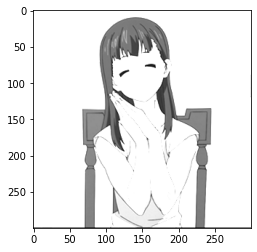

In [136]:
q03_img = maki_gs

def my_filter(dim, kernel):
  try:
    new_kernel = np.zeros((dim, dim), np.uint) + kernel
    return applyFilter(q03_img, new_kernel)
    #return cv.filter2D(src = q03_img, ddepth = -1, kernel = new_kernel, borderType=cv.BORDER_REPLICATE )
  except:
    return None

n, kernel = 3, [ [0, 0, 0], [0, 0.5, 0], [0, 1, 0.5] ]
resp = my_filter(n, kernel)
plt.imshow(cv.cvtColor(resp, cv.COLOR_BGR2RGB))
cv.imwrite("q03_img.jpg", resp)

# QUESTÃO 04

### MEDIAN BLUR
Esse filtro, diferente da maioria, não calcula um novo valor para o pixel central, apenas se utiliza da mediana dos valores encontrados dentro da matriz e substitui o valor central pela mediana desse conjunto, ela é bastante efetiva para remoção de ruídos do tipo "Salt and Pepper"

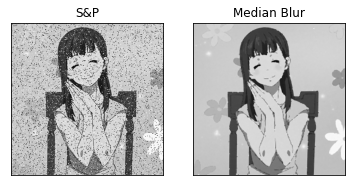

In [334]:
#Minha implementação
median_img = applyFilter(sp_noise, np.array((3,3)), True)
plt.subplot(121),plt.imshow(cv.cvtColor(sp_noise, cv.COLOR_BGR2RGB)),plt.title('S&P')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv.cvtColor(median_img, cv.COLOR_BGR2RGB)),plt.title('Median Blur')
plt.xticks([]), plt.yticks([])
plt.show()

### GAUSSIAN BLUR
Esse filtro utiliza a função Guassiana, que é uma distribuição normal, para avaliar os pixels e deixa um tom mais "desfocado", serve melhor para remoção de ruídos do tipo "Gaussiano", ou seja, que seguem uma distribuição normal

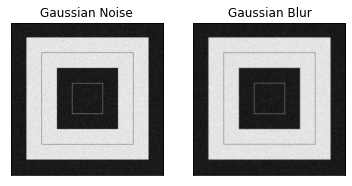

In [335]:
#Minha implementação
gauss_kernel = np.array([[1,4,7,4,1], [4,16,26,16,4], [7,26,41,26,7], [4,16,26,16,4], [1,4,7,4,1]])*(1/273)
gauss_img = applyFilter(gaussian_noise, gauss_kernel, convolution = True)
plt.subplot(121),plt.imshow(cv.cvtColor(gaussian_noise, cv.COLOR_BGR2RGB)),plt.title('Gaussian Noise')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv.cvtColor(gauss_img, cv.COLOR_BGR2RGB)),plt.title('Gaussian Blur')
plt.xticks([]), plt.yticks([])
plt.show()

# QUESTÃO 05

In [365]:
#QUESTÃO 05
#O KERNEL UTILIZADO SERÁ:
#|-1 -1 -1|
#|-1  9 -1|
#|-1 -1 -1|

#definindo n
n = 3
#gerando o kernel
hpkernel = np.ones((n,n))*(-1)
mid = ((n*n))
hpkernel[n//2][n//2] = hpkernel[n//2][n//2]*(-mid)
#hpkernel /= (n*n)
hpkernel

array([[-1., -1., -1.],
       [-1.,  9., -1.],
       [-1., -1., -1.]])

PLOT DA IMAGEM 01


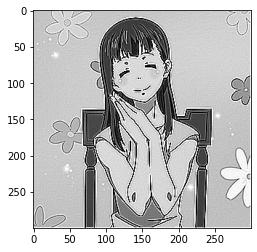

In [366]:
#plotando a imagem 01
#dst = cv.filter2D(src = maki_gs, ddepth = -1, kernel = hpkernel, borderType=cv.BORDER_REPLICATE )
dst = applyFilter(maki_gs, hpkernel)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 02


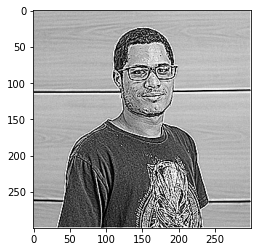

In [367]:
#plotando a imagem 02
#dst = cv.filter2D(src = eu, ddepth = -1, kernel = hpkernel, borderType=cv.BORDER_REPLICATE )
dst = applyFilter(eu_gs, hpkernel)
print("PLOT DA IMAGEM 02")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 03


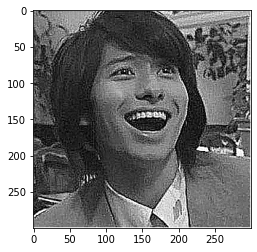

In [368]:
#plotando a imagem 03
#dst = cv.filter2D(src = otoya, ddepth = -1, kernel = hpkernel, borderType=cv.BORDER_REPLICATE )
dst = applyFilter(otoya_gs, hpkernel)
print("PLOT DA IMAGEM 03")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

In [369]:
#acrescendo 3 em n
n = n + 4
hpkernel = np.ones((n,n))*(-1)
mid = ((n*n))
hpkernel[n//2][n//2] = hpkernel[n//2][n//2]*(-mid)
#hpkernel /= (n*n)
hpkernel

array([[-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., 49., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1.]])

PLOT DA IMAGEM 01


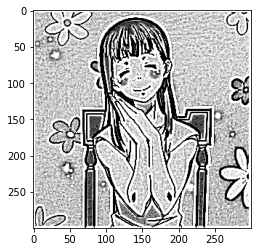

In [370]:
#plotando a imagem 01
#dst = cv.filter2D(src = maki, ddepth = -1, kernel = hpkernel, borderType=cv.BORDER_REPLICATE )
dst = applyFilter(maki_gs, hpkernel)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 02


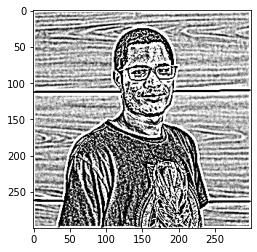

In [371]:
#plotando a imagem 02
#dst = cv.filter2D(src = eu, ddepth = -1, kernel = hpkernel, borderType=cv.BORDER_REPLICATE )
dst = applyFilter(eu_gs, hpkernel)
print("PLOT DA IMAGEM 02")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 03


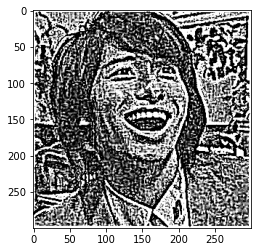

In [372]:
#plotando a imagem 03
#dst = cv.filter2D(src = otoya, ddepth = -1, kernel = hpkernel, borderType=cv.BORDER_REPLICATE )
dst = applyFilter(otoya_gs, hpkernel)
print("PLOT DA IMAGEM 03")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

Percebe-se que ao aumentar p valor de n, o efeito de sharpening vai aumentando

# QUESTÃO 06

In [336]:
#QUESTÃO 06
#O KERNEL UTILIZADO SERÁ O MEAN:
#|1 1 1|
#|1 1 1| *(1/9)
#|1 1 1|

n = 3
meanKernel = np.ones((n,n), dtype=np.float32)
meanKernel /= (n*n)
meanKernel

array([[0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111],
       [0.11111111, 0.11111111, 0.11111111]], dtype=float32)

PLOT DA IMAGEM 01


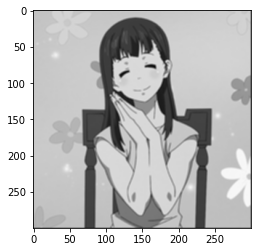

In [337]:
#plotando a imagem 01
#dst = cv.filter2D(src = maki, ddepth = -1, kernel = meanKernel, borderType=cv.BORDER_REPLICATE )
dst = applyFilter(maki_gs, meanKernel)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 02


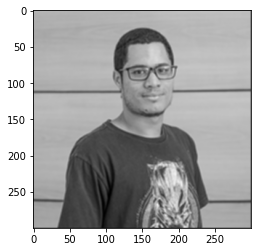

In [338]:
#plotando a imagem 02
dst = applyFilter(eu_gs, meanKernel)
print("PLOT DA IMAGEM 02")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 03


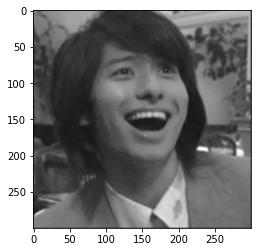

In [339]:
#plotando a imagem 03
dst = applyFilter(otoya_gs, meanKernel)
print("PLOT DA IMAGEM 03")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

In [340]:
#acrescendo em 3 o valor de n
n = n + 4
meanKernel = np.ones((n,n),dtype=np.float32)
meanKernel /= (n*n)
meanKernel

array([[0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816],
       [0.02040816, 0.02040816, 0.02040816, 0.02040816, 0.02040816,
        0.02040816, 0.02040816]], dtype=float32)

PLOT DA IMAGEM 01


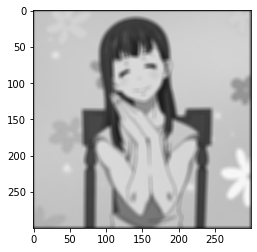

In [341]:
#plotando a imagem 01
dst = applyFilter(maki_gs, meanKernel)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 02


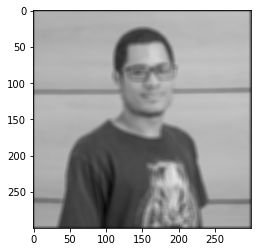

In [342]:
#plotando a imagem 02
dst = applyFilter(eu_gs, meanKernel)
print("PLOT DA IMAGEM 02")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 03


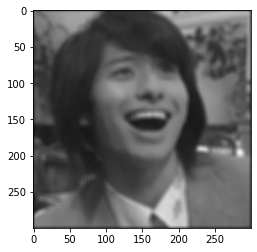

In [343]:
#plotando a imagem 03
dst = applyFilter(otoya_gs, meanKernel)
print("PLOT DA IMAGEM 03")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

Ao aumentar o valor de n, o efeito de smoothing aumenta


# QUESTÃO 07

In [344]:
# QUESTÃO 07
#O KERNEL UTILIZADO SERÁ O LAPACIAN:
#|-1 -1 -1|
#|-1  8 -1|
#|-1 -1 -1|

n = 3
lap_kernel = np.ones((n,n))*(-1)
mid = ((n*n)-1)
lap_kernel[n//2][n//2] = lap_kernel[n//2][n//2]*(-mid)

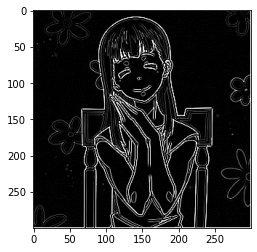

In [345]:
lap = applyFilter(maki_gs, lap_kernel)
plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB))

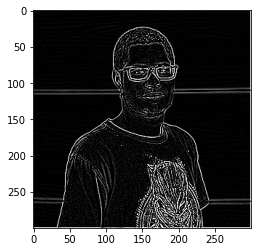

In [346]:
lap = applyFilter(eu_gs, lap_kernel)
plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB))

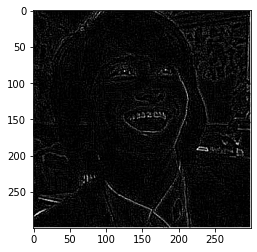

In [347]:
lap = applyFilter(otoya_gs, lap_kernel)
plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB))

In [351]:
#acrescendo 4
n = n + 4
lap_kernel = np.ones((n,n))*(-1)
mid = ((n*n)-1)
lap_kernel[n//2][n//2] = lap_kernel[n//2][n//2]*(-mid)

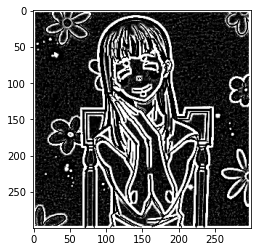

In [352]:
lap = applyFilter(maki_gs, lap_kernel)
plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB))

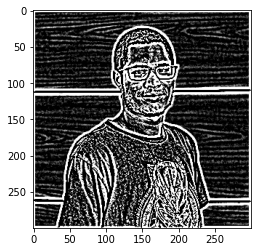

In [353]:
lap = applyFilter(eu_gs, lap_kernel)
plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB))

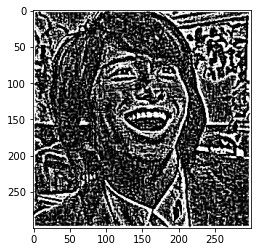

In [354]:
lap = applyFilter(otoya_gs, lap_kernel)
plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB))

Quando o n aumenta, mais edges ele consegue captar

# QUESTÃO 08

In [355]:
#QUESTÃO 08
#Os filtros serão os mesmos utilizados nas questões 05 e 06

def create_hybrid_img(img_high, img_low, high_freq, low_freq):
  if (high_freq == 0 or low_freq == 0):
    return None
    
  #creating the high-pass kernel
  hp_kernel = np.ones((high_freq,high_freq))*(-1)
  mid = (high_freq*high_freq)
  hp_kernel[high_freq//2][high_freq//2] = hp_kernel[high_freq//2][high_freq//2]*(-mid)

  #creating the low-pass kernel
  mean_kernel = np.ones((low_freq,low_freq))
  mean_kernel /= (low_freq*low_freq)

  #creating the high-pass version of the image
  #high_ver = cv.filter2D(src = img_high, ddepth = -1, kernel = hp_kernel, borderType=cv.BORDER_REPLICATE )
  high_ver = applyFilter(img_high, hp_kernel)
  #creating the low-pass version of the image
  low_ver = applyFilter(img_high, mean_kernel)

  return high_ver + low_ver

PLOT DA IMAGEM 01


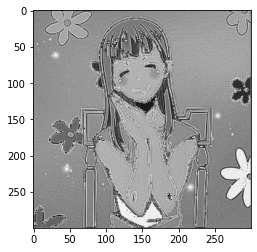

In [356]:
#plotando a imagem 01
dst = create_hybrid_img(maki_gs, maki_gs, 3, 3)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 02


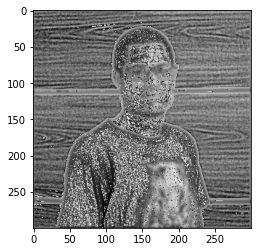

In [357]:
dst = create_hybrid_img(eu_gs, eu_gs, 5, 5)
print("PLOT DA IMAGEM 02")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 03


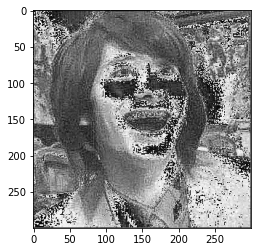

In [358]:
#plotando a imagem 03
dst = create_hybrid_img(otoya_gs, otoya_gs, 3, 3)
print("PLOT DA IMAGEM 03")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 01


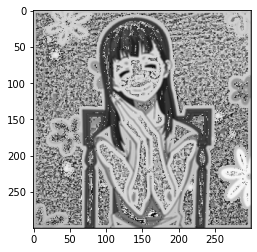

In [359]:
#plotando a imagem 01
dst = create_hybrid_img(maki_gs, maki_gs, 9, 3)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 02


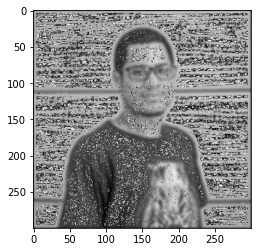

In [360]:
#plotando a imagem 01
dst = create_hybrid_img(eu_gs, eu_gs, 9, 5)
print("PLOT DA IMAGEM 02")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 03


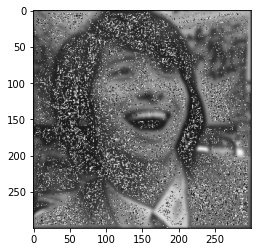

In [361]:
#plotando a imagem 03
dst = create_hybrid_img(otoya_gs, otoya_gs, 9, 5)
print("PLOT DA IMAGEM 03")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 01


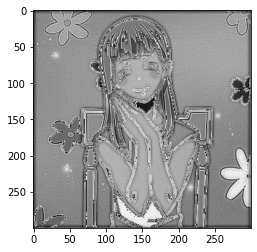

In [362]:
#plotando a imagem 01
dst = create_hybrid_img(maki_gs, maki_gs, 3, 11)
print("PLOT DA IMAGEM 01")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 02


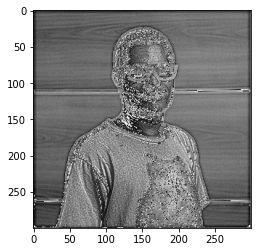

In [363]:
#plotando a imagem 01
dst = create_hybrid_img(eu_gs, eu_gs, 3, 11)
print("PLOT DA IMAGEM 02")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

PLOT DA IMAGEM 03


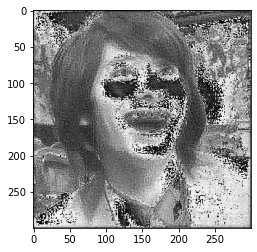

In [364]:
#plotando a imagem 03
dst = create_hybrid_img(otoya_gs, otoya_gs, 3, 11)
print("PLOT DA IMAGEM 03")
plt.imshow(cv.cvtColor(dst, cv.COLOR_BGR2RGB))

# QUESTÃO 09

imagem gerada


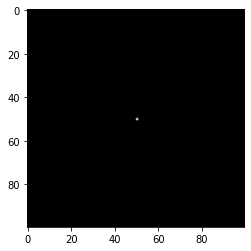

In [373]:
gauss_kernel = np.array([[1,4,7,4,1], [4,16,26,16,4], [7,26,41,26,7], [4,16,26,16,4], [1,4,7,4,1]])*(1/273)

#gerando imagem preta com 1 pixel branco no meio
white_pixel = np.zeros((100,100), np.uint8)
white_pixel[50][50] = 255
print("imagem gerada")
plt.imshow(cv.cvtColor(white_pixel, cv.COLOR_BGR2RGB))

Como os valores da imagem são, em sua maioridade, 0, em praticamente todos os pontos, a gaussiana resultará em 0, tanto na convolução quanto na cross-correlation, na grande parte das areas, por isso será calculado apenas os valores quando o pixel branco estiver aparecendo na matriz, porém há algumas coisas a serem analisadas:


*   A matriz da Gaussiana é simetrica, então apenas as ocorrências do pixel branco serao analisadas, pois serão as mesmas para a coordenada simetrica do outro lado da diagonal;
*   Quando o valor de um campo com valor X em g for calculado, em todas as ocorrrencias dele em g, será o mesmo valor;
*   A matriz se for flipada para a convolução, continuará a mesma, então a correlação cruzada de g com I e a convolução g * I resultarão nos mesmos valores;
*   Como a convolução é comutativa, g*I será o mesmo que I*g.

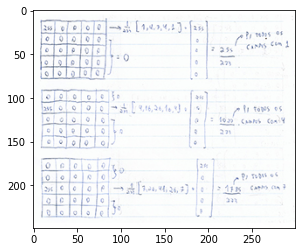

In [ ]:
q91 = cv.imread(cv.samples.findFile("vc lista 01.jpg") )
plt.imshow(cv.cvtColor(q91, cv.COLOR_BGR2RGB))

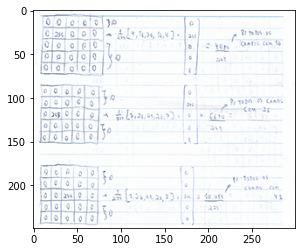

In [ ]:
q92 = cv.imread(cv.samples.findFile("vc lista 02.jpg") )
plt.imshow(cv.cvtColor(q92, cv.COLOR_BGR2RGB))

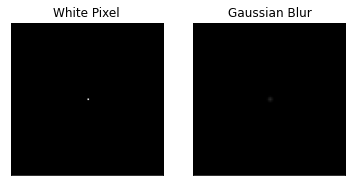

In [374]:
gauss_img = applyFilter(white_pixel, gauss_kernel, convolution = True)
plt.subplot(121),plt.imshow(cv.cvtColor(white_pixel, cv.COLOR_BGR2RGB)),plt.title('White Pixel')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cv.cvtColor(gauss_img, cv.COLOR_BGR2RGB)),plt.title('Gaussian Blur')
plt.xticks([]), plt.yticks([])
plt.show()

# QUESTÃO 10

In [375]:
def my_resize(img, sx, sy, gauss=True):
  new_img = img
  if (gauss):
    gauss_kernel = np.array([[1,4,7,4,1], [4,16,26,16,4], [7,26,41,26,7], [4,16,26,16,4], [1,4,7,4,1]])*(1/273)
    new_img = applyFilter(img, gauss_kernel, convolution = True)
  w, h = new_img.shape[1]*(sx/100), new_img.shape[0]*(sy/100)
  return cv.resize(new_img, (int(w),int(h) ))  

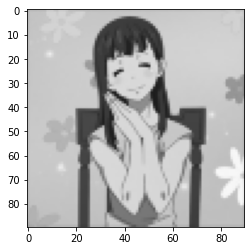

In [376]:
resized = my_resize(maki_gs, 30, 30)
plt.imshow(cv.cvtColor(resized, cv.COLOR_BGR2RGB))

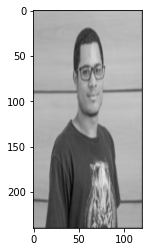

In [377]:
resized = my_resize(eu_gs, 40, 80)
plt.imshow(cv.cvtColor(resized, cv.COLOR_BGR2RGB))

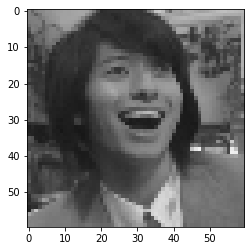

In [378]:
resized = my_resize(otoya_gs, 20, 20)
plt.imshow(cv.cvtColor(resized, cv.COLOR_BGR2RGB))

# QUESTÃO 11

In [383]:
gauss_kernel = np.array([[1,4,7,4,1], [4,16,26,16,4], [7,26,41,26,7], [4,16,26,16,4], [1,4,7,4,1]])*(1/273)

def reduce_half_img(img):
  new_img = img
  halfed, h_idx = [], -1
  for i in range(len(new_img)):
    if (i%2!=0): continue
    halfed.append([])
    h_idx += 1
    for j in range(len(new_img[i])):
      if (j%2!=0): continue
      halfed[h_idx].append(new_img[i][j])
  return np.array(halfed, np.uint8)

def build_pyramid(img, gauss=True):
  img_l, img_c = img.shape[0], img.shape[1]
  pyramid = np.zeros(( img_l, img_c + (img_c//2)), np.uint8)
  down = 0
  #adicionando a versao original
  for i in range(len(img)):
    for j in range(len(img[i])):
      pyramid[i][j] = img[i][j]
  new_img = img
  #enqnt nao for apenas 1 pixel
  while new_img.shape[0] != 1:
    if (gauss):
      new_img = applyFilter(new_img, gauss_kernel, convolution = True)
    new_img = reduce_half_img(new_img)
    for i in range(len(new_img)):
      for j in range(len(new_img[i])):
        pyramid[i+down][j+img_c] = new_img[i][j]
    down += new_img.shape[0]
  return pyramid

True

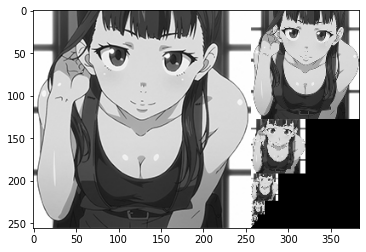

In [382]:
pyramid = build_pyramid(maki1024_gs, False)
plt.imshow(cv.cvtColor(pyramid, cv.COLOR_BGR2RGB))
cv.imwrite("pyramid.jpg", pyramid)

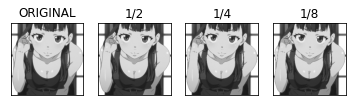

In [391]:
plt.subplot(141),plt.imshow(cv.cvtColor(maki1024_gs, cv.COLOR_BGR2RGB)),plt.title('ORIGINAL')
plt.xticks([]), plt.yticks([])

half_maki = reduce_half_img(maki1024_gs)
plt.subplot(142),plt.imshow(cv.cvtColor(half_maki, cv.COLOR_BGR2RGB)),plt.title('1/2')
plt.xticks([]), plt.yticks([])

quarter_maki = reduce_half_img(half_maki)
plt.subplot(143),plt.imshow(cv.cvtColor(quarter_maki, cv.COLOR_BGR2RGB)),plt.title('1/4')
plt.xticks([]), plt.yticks([])

eight_maki = reduce_half_img(quarter_maki)
plt.subplot(144),plt.imshow(cv.cvtColor(quarter_maki, cv.COLOR_BGR2RGB)),plt.title('1/8')
plt.xticks([]), plt.yticks([])
plt.show()

True

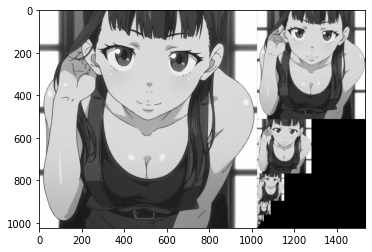

In [381]:
#OBS: ESSE CODIGO DEMORA PARA RODAR DEVIDO AS DIMENSÕES DA IMAGEM
gauss_pyramid = build_pyramid(maki1024_gs)
plt.imshow(cv.cvtColor(gauss_pyramid, cv.COLOR_BGR2RGB))
cv.imwrite("gauss_pyramid.jpg", gauss_pyramid)

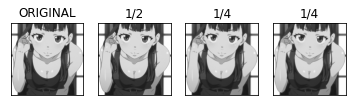

In [388]:
#OBS: ESSE CODIGO DEMORA PARA RODAR DEVIDO AS DIMENSÕES DA IMAGEM
plt.subplot(141),plt.imshow(cv.cvtColor(maki1024_gs, cv.COLOR_BGR2RGB)),plt.title('ORIGINAL')
plt.xticks([]), plt.yticks([])

half_maki = reduce_half_img(applyFilter(maki1024_gs, gauss_kernel, convolution = True))
plt.subplot(142),plt.imshow(cv.cvtColor(half_maki, cv.COLOR_BGR2RGB)),plt.title('1/2')
plt.xticks([]), plt.yticks([])

quarter_maki = reduce_half_img(applyFilter(half_maki, gauss_kernel, convolution = True)) 
plt.subplot(143),plt.imshow(cv.cvtColor(quarter_maki, cv.COLOR_BGR2RGB)),plt.title('1/4')
plt.xticks([]), plt.yticks([])

eight_maki = reduce_half_img(applyFilter(quarter_maki, gauss_kernel, convolution = True)) 
plt.subplot(144),plt.imshow(cv.cvtColor(quarter_maki, cv.COLOR_BGR2RGB)),plt.title('1/8')
plt.xticks([]), plt.yticks([])
plt.show()

# QUESTÃO 12

In [392]:
#filtros de derivada

#O KERNEL UTILIZADO SERÁ O LAPACIAN:
#|-1 -1 -1|
#|-1  8 -1|
#|-1 -1 -1|

n = 3
lap_kernel = np.ones((n,n))*(-1)
mid = ((n*n)-1)
lap_kernel[n//2][n//2] = lap_kernel[n//2][n//2]*(-mid)

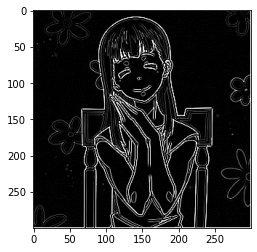

In [393]:
lap = applyFilter(maki_gs, lap_kernel)
plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB))

In [394]:
#SOBEL OPERATOR:
#|-1  0  1|      |-1 -2 -1|
#|-2  0  2| gx   | 0  0  0| gy
#|-1  0  1|      | 1  2  1|

gx = np.array([ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1] ])
gy = np.array([ [-1, -2, -1], [0, 0, 0], [1, 2, 1] ])

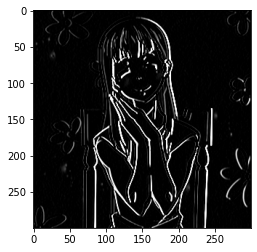

In [395]:
#PARA X
dstx = applyFilter(maki_gs, gx)
plt.imshow(cv.cvtColor(dstx, cv.COLOR_BGR2RGB))

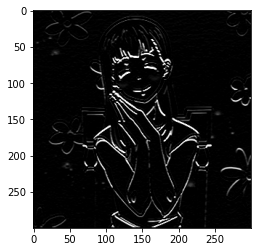

In [396]:
#PARA Y
dsty = applyFilter(maki_gs, gy)
plt.imshow(cv.cvtColor(dsty, cv.COLOR_BGR2RGB))

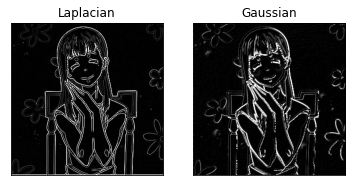

In [398]:
plt.subplot(121),plt.imshow(cv.cvtColor(lap, cv.COLOR_BGR2RGB)),plt.title('Laplacian')
plt.xticks([]), plt.yticks([])

plt.subplot(122),plt.imshow(cv.cvtColor(dstx+dsty, cv.COLOR_BGR2RGB)),plt.title('Gaussian')
plt.xticks([]), plt.yticks([])
plt.show()

A versão com gaussiana se mostra mais suavizada, enquanto a versão laplaciana foca melhor nas linhas e parece menos "fofo" nas arestas

# QUESTÃO 13

In [ ]:
#supressão nao maxima

Referencias
Filtros: https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html

https://docs.opencv.org/master/d4/dbd/tutorial_filter_2d.html

https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html





3,4,5,6,7 -> na mao

1,2 -> vai fik ruido

5,6,7 -> pode acrescer 4
